DataFrame for ticker A is empty after filtering. Skipping this ticker.
DataFrame for ticker AABA is empty after filtering. Skipping this ticker.
DataFrame for ticker AEC is empty after filtering. Skipping this ticker.
DataFrame for ticker ALD is empty after filtering. Skipping this ticker.
DataFrame for ticker ANF is empty after filtering. Skipping this ticker.
DataFrame for ticker APOL is empty after filtering. Skipping this ticker.
DataFrame for ticker BEAM is empty after filtering. Skipping this ticker.
DataFrame for ticker BMS is empty after filtering. Skipping this ticker.
DataFrame for ticker BTU is empty after filtering. Skipping this ticker.
Dataframe für Aktie CFN ist leer nach Entfernen von NaNs. Wird Übersprungen.
DataFrame for ticker CLF is empty after filtering. Skipping this ticker.
DataFrame for ticker COP is empty after filtering. Skipping this ticker.
DataFrame for ticker COV is empty after filtering. Skipping this ticker.
DataFrame for ticker CWGL is empty after filte

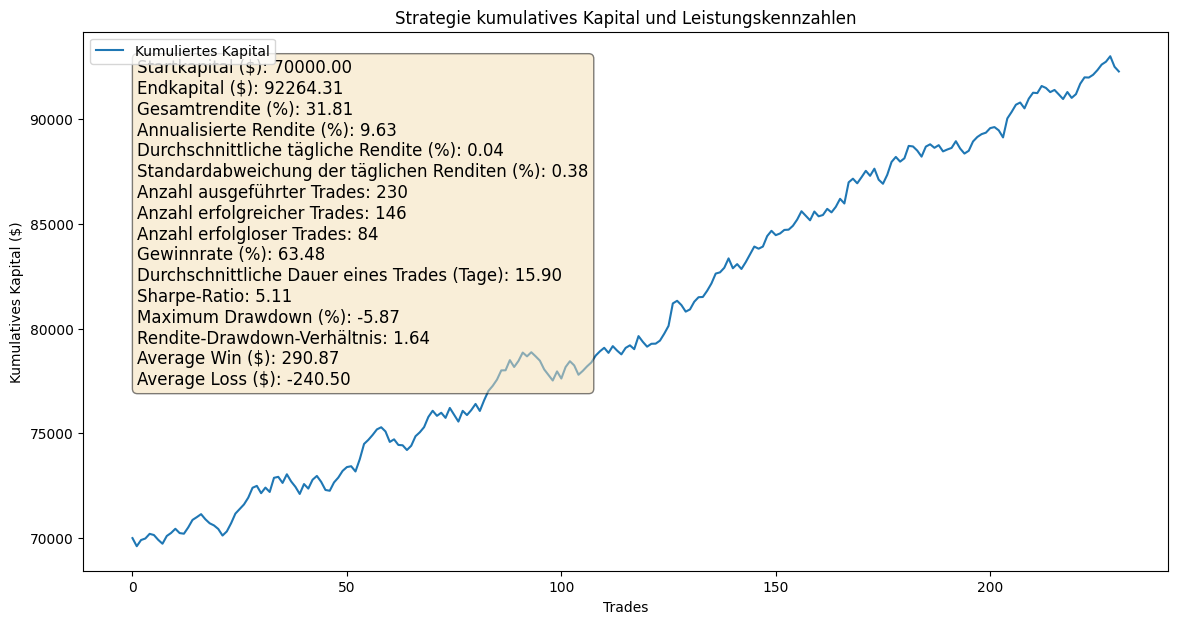

Ergebnisse für AA:
Startkapital ($): 70000
Endkapital ($): 70000
Gesamtrendite (%): 0.0
Annualisierte Rendite (%): 0
Durchschnittliche tägliche Rendite (%): 0.0
Standardabweichung der täglichen Renditen (%): nan
trade_entries: []
trade_exits: []
trades: []


Ergebnisse für AAL:
Startkapital ($): 70000
Endkapital ($): 70000
Gesamtrendite (%): 0.0
Annualisierte Rendite (%): 0.0
Durchschnittliche tägliche Rendite (%): 0.0
Standardabweichung der täglichen Renditen (%): 2.149294191248024
trade_entries: []
trade_exits: []
trades: []


Ergebnisse für AAP:
Startkapital ($): 70000
Endkapital ($): 70000
Gesamtrendite (%): 0.0
Annualisierte Rendite (%): 0.0
Durchschnittliche tägliche Rendite (%): 0.0
Standardabweichung der täglichen Renditen (%): 2.218665656887216
trade_entries: []
trade_exits: []
trades: []


Ergebnisse für AAPL:
Startkapital ($): 70000
Endkapital ($): 70427.547755
Gesamtrendite (%): 0.610782507142867
Annualisierte Rendite (%): 0.2083230106323608
Durchschnittliche tägliche Rendi

In [4]:
# Importieren der benötigten Bibliotheken bzw. Module, müssen ggf. vorher mit pip installiert werden
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import numpy as np
import math

# Funktion, um Datensatz in einen Dataframe zu laden und Zeitraum zu beschränken
def load_csv_to_dataframe(file_path, start_date, end_date):
    df = pd.read_csv(file_path, parse_dates=True, index_col='date')
    df.index = pd.to_datetime(df.index, errors='coerce')
    df.dropna(inplace=True)
    
    # Zeitraum wird beschränkt
    df = df.loc[start_date:end_date]
    return df

# Verzeichnis des benutzten Datensatz, ggf. muss die "tickers.csv" Datei vorher aus dem Zielordner entfernt werden.
data_dir = "C:\\Users\\Moritz\\Desktop\\bereinigte SP500 Data\\survivorship-free-spy-master\\survivorship-free\\Datenlul"

# Liste der Aktienticker bzw. der Dateinamen 
tickers = [f.replace('.csv', '') for f in os.listdir(data_dir) if f.endswith('.csv')]

# Zeitraum wird festgelegt auf den Out-of-Sample-Zeitraum
start_date = "2015-02-28"
end_date = "2018-02-28"

# Funktion, die die ganzen Indikatoren hinzufügt
def add_indicators(df):
    df['200_EMA'] = df['close'].ewm(span=200, adjust=False).mean()
    df['RSI'] = ta.rsi(df['close'], length=14)
    df['BB_middle'] = df['close'].rolling(window=20).mean()
    df['BB_std'] = df['close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * 2)
    df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * 2)
    df['BB_bandwidth'] = df['BB_upper'] - df['BB_lower']
    short_vol = df['volume'].ewm(span=10, adjust=False).mean()
    long_vol = df['volume'].ewm(span=20, adjust=False).mean()
    df['Volume_Oscillator'] = 100 * (short_vol - long_vol) / long_vol
    return df

# Klasse, in der die Funktionsweise der Mean-Reversion-Strategie steht
class TradingStrategy:
    # Initialisierung
    def __init__(self, df, ticker, initial_capital=70000, risk_per_trade=200, stop_loss_percent=3, take_profit_percent=3, verbose=False):
        self.df = df  # Dataframe, der die Aktiendaten enthält
        self.ticker = ticker  # Ticker der Aktien
        self.initial_capital = initial_capital  # Startkapital
        self.risk_per_trade = risk_per_trade  # Risiko pro Trade
        self.stop_loss_percent = stop_loss_percent  # Stop-Loss %
        self.take_profit_percent = take_profit_percent # Take-Profit %, wurde vor allem beim Entwicklung für Tests benutzt
        self.verbose = verbose  # Optional
        self.position = None  # Aktuelle Position vom Trade
        self.entry_price = None  # Einstiegspreis
        self.stop_loss = None  # Stop-Loss Preis
        self.take_profit = None # Take-Profit Preis
        self.capital = initial_capital # Verfügbares Kapital
        self.total_profit = 0  # Gesamter Gewinn bzw. Verlust aus allen Trades
        self.trades = []  # Liste aller abgeschlossenen Trades
        self.trade_durations = []  # Liste der Dauer jedes Trades
        self.trade_entries = []  # Liste der Einstiegszeitpunkte
        self.trade_exits = []  # Liste der Ausstiegszeitpunkte
        self.stop_losses = []  # Liste der Stop-Losses
        self.exit_signals = []  # Liste von Daten bei Erfüllung vom Ausstiegssignals
        self.transaction_cost_fixed = 2  # Direkte Transaktionskosten
        self.transaction_cost_percent = 0.0005  # Indirekte Transaktionskosten
    # Funktion zur Anwendung der Strategie
    def apply_strategy(self):
        entry_date = None

        for i in range(len(self.df) - 1):  # Iteration
            row = self.df.iloc[i]  # Aktuelle Zeile im DataFrame
            next_row = self.df.iloc[i + 1]  # Nächste Zeile im DataFrame
            
            if self.position is None:
                # Einstiegssignal
                if row['close'] < row['BB_lower'] and row['RSI'] < 30 and row['close'] > row['200_EMA'] and row['Volume_Oscillator'] > 0:
                    self.position = 'long'  # Long-Position
                    self.entry_price = next_row['open']  # Verwendung des Open-Preis des nächsten Tages, wegen Lookahead-Bias
                    self.stop_loss = self.entry_price * (1 - self.stop_loss_percent / 100)
                    self.take_profit = self.entry_price * (1 + self.take_profit_percent / 100)
                    position_size = math.floor(self.risk_per_trade / (self.entry_price - self.stop_loss))  # Positionsgröße auf ganze Zahl abrunden
                    entry_date = self.df.index[i + 1]
                    self.trade_entries.append((entry_date, self.ticker, self.entry_price, position_size))  # Speichern vom Einstiegsdatum + Details
                    self.stop_losses.append(self.stop_loss)  # Speichern vom Stop-Loss
                    if self.verbose:
                        print(f"Long-Trade am {entry_date} bei {self.entry_price} mit Positionsgröße von {position_size}")

            elif self.position == 'long':
                # Ausstiegssignal
                if row['close'] > row['BB_middle'] or row['close'] <= self.stop_loss:
                    self.exit_signals.append(self.df.index[i])  # Speichern des Datums
                    exit_price = next_row['open']  # Verwendung vom Open-Preis des nächsten Tages, wegen Lookahead-Bias
                    profit = (exit_price - self.entry_price) * position_size
                    # Transaktionskosten berechnen
                    transaction_costs = (self.transaction_cost_fixed + (self.entry_price * self.transaction_cost_percent * position_size)) + \
                                        (self.transaction_cost_fixed + (exit_price * self.transaction_cost_percent * position_size))
                    profit -= transaction_costs
                    self.total_profit += profit
                    self.capital += profit  # Anpassung laufendes Kapital
                    self.trades.append(profit)
                    # Berechnung der Dauer des Trades, sowohl der Ein- als auch der Ausstiegstag werden mitgezählt
                    duration = (self.df.index[i + 1] - entry_date).days + 1
                    self.trade_durations.append(duration)
                    self.trade_exits.append((self.df.index[i + 1], exit_price, profit, transaction_costs, duration))  # Speichern vom Ausstiegsdatum + Details
                    if self.verbose:
                        print(f"Long-Trade Ausstieg am {self.df.index[i + 1]} bei {exit_price} mit Gewinn von {profit} nach Transaktionskosten von {transaction_costs}")
                    self.position = None

        if self.verbose:
            print(f"Total Profit: {self.total_profit}")
            print(f"Ending Capital: {self.capital}")

    # Funktion zur Berechnung der Kennzahlen
    def calculate_metrics(self):
        total_return = (self.capital - self.initial_capital) / self.initial_capital * 100

        # Annualisierte Rendite
        num_days = (self.df.index[-1] - self.df.index[0]).days
        if num_days > 0:
            annualized_return = ((self.capital / self.initial_capital) ** (365.0 / num_days) - 1) * 100
        else:
            annualized_return = 0

        # Berechnung der täglichen Renditen
        self.df['daily_return'] = self.df['close'].pct_change()
        daily_returns = self.df['daily_return'].dropna()

        # Durchschnittliche tägliche Rendite auf Basis der annualisierten Rendite
        avg_daily_return = ((1 + annualized_return / 100) ** (1 / 252) - 1) * 100

        # Berechnung der Standardabweichung der täglichen Renditen
        std_daily_return = daily_returns.std() * 100

        metrics = {
            'Startkapital ($)': self.initial_capital,
            'Endkapital ($)': self.capital,
            'Gesamtrendite (%)': total_return,
            'Annualisierte Rendite (%)': annualized_return,
            'Durchschnittliche tägliche Rendite (%)': avg_daily_return,
            'Standardabweichung der täglichen Renditen (%)': std_daily_return,
            'trade_entries': self.trade_entries,
            'trade_exits': self.trade_exits,
            'trades': self.trades
        }

        return metrics

# Funktion die Strategie auf alle Daten anwendet
def analyze_all_tickers(data_dir, tickers, start_date, end_date):
    initial_capital = 70000
    total_profit_all_tickers = 0
    combined_trades = []
    combined_trade_dates = []
    combined_trade_durations = []
    trade_details = []
    results = []
    combined_capital = initial_capital

    for ticker in tickers:
        file_path = os.path.join(data_dir, f"{ticker}.csv")

        df = load_csv_to_dataframe(file_path, start_date, end_date)

        # Überprüfung, ob DataFrame leer ist
        if df.empty:
            print(f"DataFrame for ticker {ticker} is empty after filtering. Skipping this ticker.")
            continue

        # Hinzufügen von Indikatoren
        df = add_indicators(df)

        # Zeilen mit NaN-Werten in den Indikatoren entfernen
        df.dropna(inplace=True)
        
        # Überprüfen, ob der DataFrame nach dem Entfernen der NaN-Werte leer ist
        if df.empty:
            print(f"Dataframe für Aktie {ticker} ist leer nach Entfernen von NaNs. Wird Übersprungen.")
            continue

        # Strategie anwenden
        strategy = TradingStrategy(df, ticker, initial_capital=combined_capital, risk_per_trade=200, verbose=False)
        strategy.apply_strategy()

        # Erfassung von Gewinn und Trades für den aktuellen Ticker
        metrics = strategy.calculate_metrics()
        results.append((ticker, metrics))
        combined_trades.extend(strategy.trades)
        combined_trade_dates.extend(strategy.trade_entries)
        combined_trade_durations.extend(strategy.trade_durations)
        for entry, exit in zip(strategy.trade_entries, strategy.trade_exits):
            trade_details.append({
                'Ticker': ticker,
                'Entry Date': entry[0],
                'Entry Price': entry[2],
                'Position Size': entry[3],
                'Exit Date': exit[0],
                'Exit Price': exit[1],
                'Profit': exit[2],
                'Transaction Costs': exit[3],
                'Duration': exit[4]
            })

    # Sortierung der Trades nach Datum
    trade_details_sorted = sorted(trade_details, key=lambda x: x['Entry Date'])
    sorted_trades_and_dates = sorted(zip(combined_trade_dates, combined_trades), key=lambda x: x[0])
    sorted_trades = [trade for _, trade in sorted_trades_and_dates]

    # Berechnung weiterer Kennzahlen
    num_trades = len(combined_trades)
    num_winning_trades = len([t for t in combined_trades if t > 0])
    num_losing_trades = len([t for t in combined_trades if t < 0])
    avg_win = np.mean([t for t in combined_trades if t > 0]) if num_winning_trades > 0 else 0
    avg_loss = np.mean([t for t in combined_trades if t < 0]) if num_losing_trades > 0 else 0
    avg_duration = np.mean(combined_trade_durations) if combined_trade_durations else 0

    if len(combined_trades) == 0:
        print("Es konnten keine Trades durchgeführt werden. Kennzahlen können nicht berechnet werden.")
        return results, {}, []

    combined_capital = initial_capital + sum(sorted_trades)
    total_return = (combined_capital - initial_capital) / initial_capital * 100

    # Annualisierte Rendite
    num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
    if num_days > 0:
        annualized_return = ((combined_capital / initial_capital) ** (365.0 / num_days) - 1) * 100
    else:
        annualized_return = 0

    # Kumuliertes Kapital
    cumulative_capital = [initial_capital] + list(initial_capital + np.cumsum(sorted_trades))

    # Berechnung der täglichen Renditen zum kumulierte Kapital
    cumulative_capital_series = pd.Series(cumulative_capital)
    cumulative_capital_daily_returns = cumulative_capital_series.pct_change().dropna()

    # Durchschnittliche tägliche Rendite auf Basis der annualisierten Rendite
    avg_daily_return_combined = ((1 + annualized_return / 100) ** (1 / 252) - 1) * 100

    # Berechnung der Standardabweichung der täglichen Renditen
    std_daily_return_combined = cumulative_capital_daily_returns.std() * 100

    if num_trades > 1:
        avg_daily_return = np.mean(combined_trades) / initial_capital
        std_daily_return = np.std(combined_trades) / initial_capital
        sharpe_ratio = (avg_daily_return / std_daily_return) * np.sqrt(252) if std_daily_return != 0 else 0
    else:
        sharpe_ratio = 0

    # Drawdown
    if len(sorted_trades) > 0:
        cumulative_returns = np.cumsum(sorted_trades)
        drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
        max_drawdown = np.min(drawdowns)
        max_drawdown_percentage = max_drawdown / np.maximum.accumulate(cumulative_returns).max() * 100 if len(cumulative_returns) > 0 else 0
    else:
        max_drawdown_percentage = 0

    profit_to_drawdown_ratio = annualized_return / abs(max_drawdown_percentage) if max_drawdown_percentage != 0 else 0

    combined_metrics = {
        'Startkapital ($)': initial_capital,
        'Endkapital ($)': combined_capital,
        'Gesamtrendite (%)': total_return,
        'Annualisierte Rendite (%)': annualized_return,
        'Durchschnittliche tägliche Rendite (%)': avg_daily_return_combined,
        'Standardabweichung der täglichen Renditen (%)': std_daily_return_combined,
        'Anzahl ausgeführter Trades': num_trades,
        'Anzahl erfolgreicher Trades': num_winning_trades,
        'Anzahl erfolgloser Trades': num_losing_trades,
        'Gewinnrate (%)': (num_winning_trades / num_trades * 100) if num_trades > 0 else 0,
        'Durchschnittliche Dauer eines Trades (Tage)': avg_duration,
        'Sharpe-Ratio': sharpe_ratio,
        'Maximum Drawdown (%)': max_drawdown_percentage,
        'Rendite-Drawdown-Verhältnis': profit_to_drawdown_ratio,
        'Average Win ($)': avg_win,
        'Average Loss ($)': avg_loss
    }

    return results, combined_metrics, sorted_trades, trade_details_sorted

# Plotten der Strategie Ergebnisse + Ausgabe Kennzahlen im Graph
def plot_strategy_results(results, combined_metrics, sorted_trades):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Kumulierte Kapital berechnen
    cumulative_capital = [70000] + list(70000 + np.cumsum(sorted_trades))
    ax.plot(cumulative_capital, label="Kumuliertes Kapital")
    
    # Annotieren der Kennzahlen, mit 2 Kommastellen
    textstr = '\n'.join((
        f"Startkapital ($): {combined_metrics['Startkapital ($)']:.2f}",
        f"Endkapital ($): {combined_metrics['Endkapital ($)']:.2f}",
        f"Gesamtrendite (%): {combined_metrics['Gesamtrendite (%)']:.2f}",
        f"Annualisierte Rendite (%): {combined_metrics['Annualisierte Rendite (%)']:.2f}",
        f"Durchschnittliche tägliche Rendite (%): {combined_metrics['Durchschnittliche tägliche Rendite (%)']:.2f}",
        f"Standardabweichung der täglichen Renditen (%): {combined_metrics['Standardabweichung der täglichen Renditen (%)']:.2f}",
        f"Anzahl ausgeführter Trades: {combined_metrics['Anzahl ausgeführter Trades']}",
        f"Anzahl erfolgreicher Trades: {combined_metrics['Anzahl erfolgreicher Trades']}",
        f"Anzahl erfolgloser Trades: {combined_metrics['Anzahl erfolgloser Trades']}",
        f"Gewinnrate (%): {combined_metrics['Gewinnrate (%)']:.2f}",
        f"Durchschnittliche Dauer eines Trades (Tage): {combined_metrics['Durchschnittliche Dauer eines Trades (Tage)']:.2f}",
        f"Sharpe-Ratio: {combined_metrics['Sharpe-Ratio']:.2f}",
        f"Maximum Drawdown (%): {combined_metrics['Maximum Drawdown (%)']:.2f}",
        f"Rendite-Drawdown-Verhältnis: {combined_metrics['Rendite-Drawdown-Verhältnis']:.2f}",
        f"Average Win ($): {combined_metrics['Average Win ($)']:.2f}",
        f"Average Loss ($): {combined_metrics['Average Loss ($)']:.2f}"
    ))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    ax.set_title("Strategie kumulatives Kapital und Leistungskennzahlen")
    ax.set_xlabel("Trades")
    ax.set_ylabel("Kumulatives Kapital ($)")
    ax.legend()
    plt.show()
    
    # Ergebnisse anzeigen
    for ticker, metrics in results:
        print(f"Ergebnisse für {ticker}:")
        for key, value in metrics.items():
            print(f"{key}: {value}")
        print("\n")

    print("Kombinierte Kennzahlen für alle Ticker:")
    for key, value in combined_metrics.items():
        print(f"{key}: {value}")

    print(f"Endkapital für alle Ticker: {combined_metrics['Endkapital ($)']}")

# Funktion zur Generierung eines .csv bzw. Excel-Dokuments
def save_trades_to_csv(trade_details, file_path):
    df = pd.DataFrame(trade_details)
    df.to_csv(file_path, index=False)

# Anwendung der Funktionen
results, combined_metrics, sorted_trades, trade_details_sorted = analyze_all_tickers(data_dir, tickers, start_date, end_date)
plot_strategy_results(results, combined_metrics, sorted_trades)

# Optional: Generierung .csv Dokument mit allen Trade-Details auf Desktop
########save_trades_to_csv(trade_details_sorted, "Trade_Details_outofsample.csv")


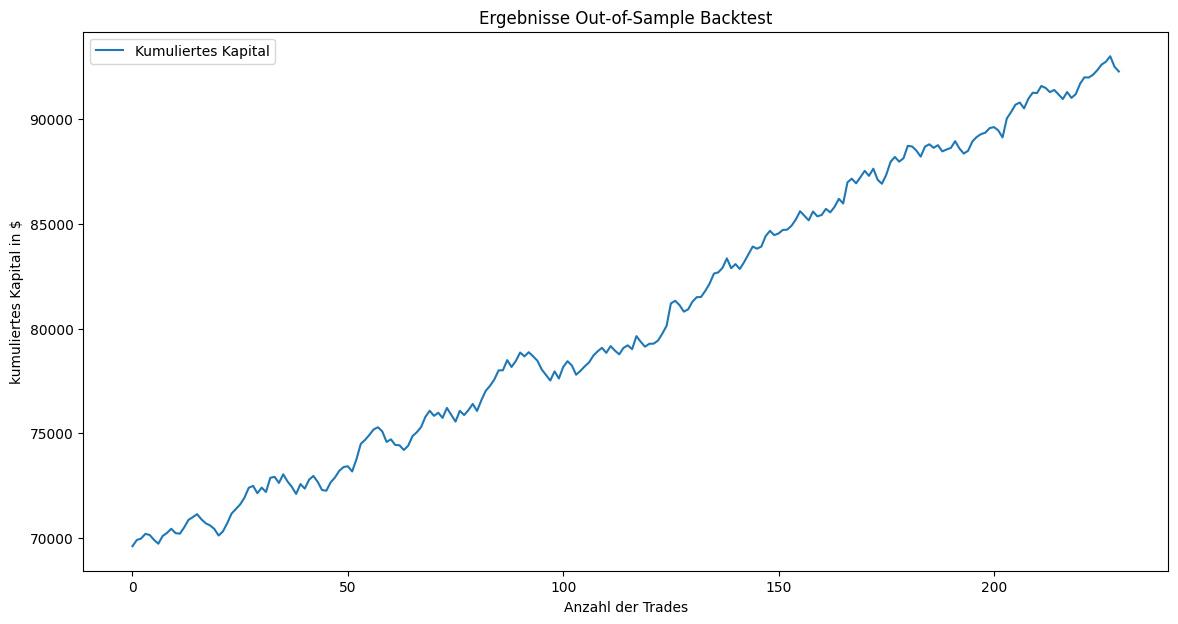

In [5]:
# Nochmal eine Funktion zum Graphen, aber ohne Trade Details
def plot_cumulative_capital(combined_trades):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Kumulierte Kapital berechnen
    cumulative_capital = 70000 + np.cumsum(combined_trades)
    ax.plot(cumulative_capital, label="Kumuliertes Kapital")

    ax.set_title("Ergebnisse Out-of-Sample Backtest")
    ax.set_xlabel("Anzahl der Trades")
    ax.set_ylabel("kumuliertes Kapital in $")
    ax.legend()
    plt.show()
    

plot_cumulative_capital(sorted_trades)